# SAT Optics Simulation: Near-field

This notebook shows the optical path of the Simons Observatory SAT optics tube.  The ray-trace produces the electric field at the window (opening) of the SAT, which is in the near-field.  This field is convolved with a square to reproduce holography measurements, since the holography source emits its signal out of a rectangular feedhorn. 

Grace E. Chesmore
March 2022

### Optical Path
We first ray-trace from the focal plane through the 3 lenses, and out to 300mm in front of the window.  The $\verb|tele_geo.y_source|$ variable changes the plane of the rays in front of the window, since this is where the holography source will eventually scan. 

The $\verb|ray_trace.rx_to_lyot|$ outputs the amplitude and pathlength $d_{\text{PL}}$ of the rays in front of the window.  The pathlength information can be converted to phase $\phi$ due to the relationship:
$$ \phi = d_{\text{PL}} \frac{\lambda}{2\pi}$$

/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ot_geo.py:69: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ot_geo.py:69: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))


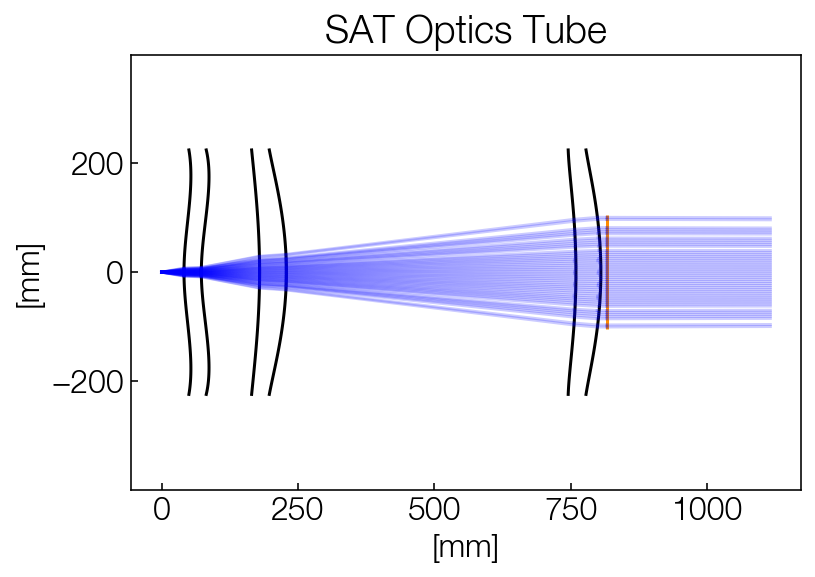

<ipython-input-1-3195f9512220>:56: RuntimeWarning: divide by zero encountered in log10
  c=20 * np.log10(output_rx[4][cc] / np.max(output_rx[4][cc])),


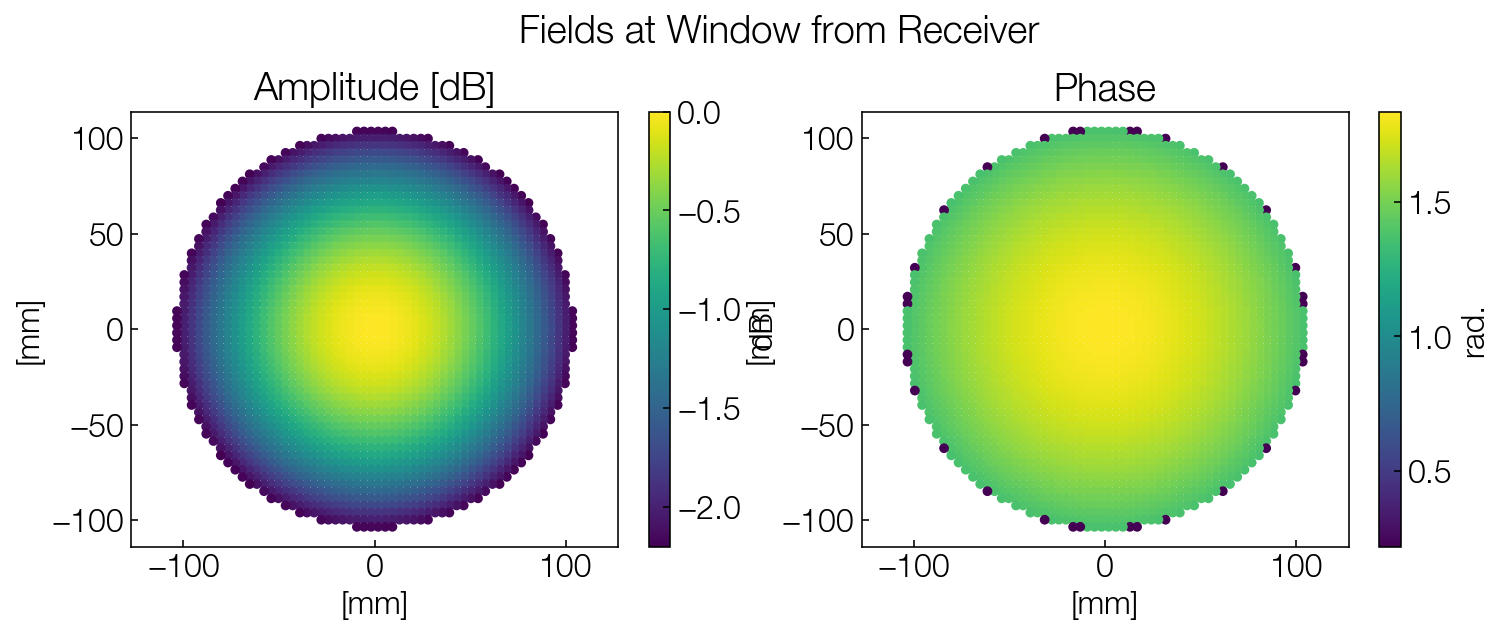

In [1]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext blackcellmagic

font_manager.fontManager.addfont(
    "/home/chesmore/.local/share/fonts/HelveticaNeueLight.ttf"
)
matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update({"axes.grid" : False, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})
%config InlineBackend.figure_format = 'retina'

import imp
ot_geo = imp.load_source('ot_geo', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ot_geo.py')
ray_trace = imp.load_source('ray_trace', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ray_trace.py')
opt_analyze = imp.load_source('opt_analyze', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/opt_analyze.py')

tele_geo = ot_geo.LatGeo()
tele_geo.n_scan = 100
tele_geo.y_source = ot_geo.y_lyot + 300

plt.figure(figsize = (6,4))
output_rx = ray_trace.rx_to_lyot([0, 0, 0], tele_geo, 1, "b")
plt.vlines(x=ot_geo.y_lyot, ymin=-105, ymax=105, color="darkorange", linestyle="-")
plt.title("SAT Optics Tube")
plt.ylabel("[mm]")
plt.xlabel("[mm]")
plt.axis("equal")
plt.show()

cc = np.where(output_rx[0] ** 2 + output_rx[2] ** 2 < (210 / 2) ** 2)

plt.figure(figsize=(12, 4))
plt.suptitle("Fields at Window from Receiver", y=1.05)
plt.subplot(122)
plt.scatter(
    output_rx[0][cc],
    output_rx[2][cc],
    c=np.mod(
        tele_geo.k * (output_rx[3][cc] - np.mean(output_rx[3][cc])) / 1e3, 2 * np.pi
    ),
    s=15,
)
plt.colorbar(label="rad.")
plt.axis("equal")
plt.title("Phase")
plt.xlabel("[mm]")
plt.ylabel("[mm]")
plt.subplot(121)
plt.scatter(
    output_rx[0][cc],
    output_rx[2][cc],
    c=20 * np.log10(output_rx[4][cc] / np.max(output_rx[4][cc])),
    s=15,
)
plt.colorbar(label="dB")
plt.axis("equal")
plt.title("Amplitude [dB]")
plt.xlabel("[mm]")
plt.ylabel("[mm]")
plt.show()

## Holography Measurement

We will eventually measure these fields with holography.  A rectangular feedhorn emits the signal into the optics tube, convolving the measured beam, and therefor we need to account for this convolution in our simulation. 

A convolution of the fields shows the amplitude of the beam fall off quickly at ~10cm radius from center.  The phase also remains relatively constant in front of the window. 

<ipython-input-6-789b343a8123>:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x/1e1, y/1e1, 20 * np.log10(abs(beam_final) / np.max(abs(beam_final))), vmin=-50,shading = 'auto')
<ipython-input-6-789b343a8123>:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x/1e1, y/1e1, np.arctan2(np.imag(beam_final),np.real(beam_final)),vmin = 0.1,vmax = .75,shading = 'auto')


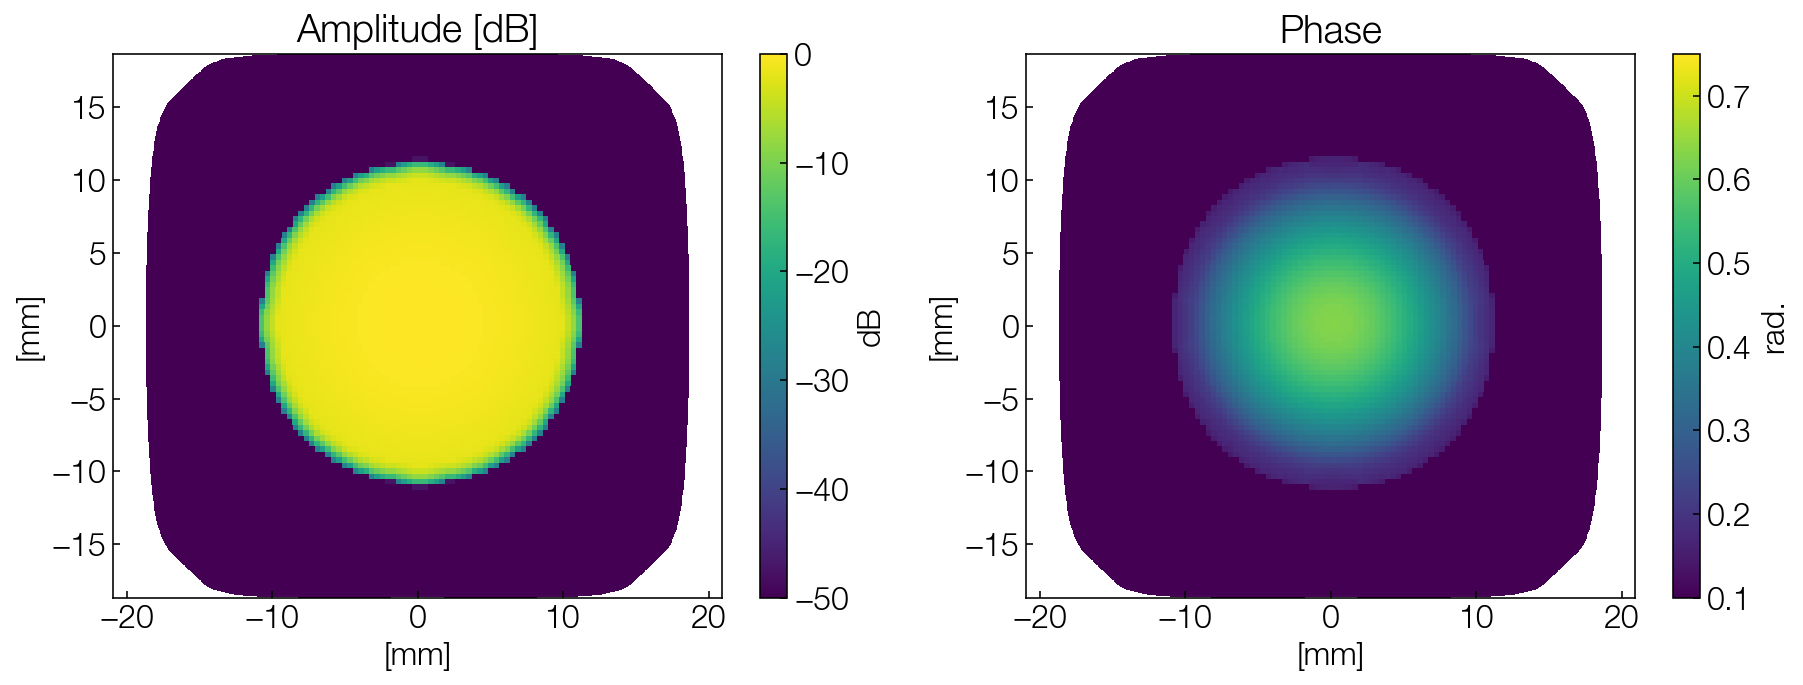

In [6]:
# Regrid the ray-trace results into a 2D grid for easier plotting purposes
len_sim = int(np.sqrt(len(output_rx[0])))
x_sim = np.reshape(output_rx[0], (len_sim, len_sim)) - np.mean(output_rx[0])  # [mm]
y_sim = np.reshape(output_rx[2], (len_sim, len_sim)) - np.mean(output_rx[2])  # [mm]
a_sim = np.reshape(output_rx[4], (len_sim, len_sim))
p_sim = np.reshape(output_rx[3], (len_sim, len_sim))
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3, 2 * np.pi)

# Define the complex beam from ray-trace outputs
noise = 1e-5 # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))
a_sim += noise

beam_sim = a_sim * np.exp(np.complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 15 # [mm]
apert2 = 19 # [mm]

# Convolve beam
x, y, beam_final = opt_analyze.beam_convolve(
    np.real(x_sim), np.real(y_sim), beam_sim, apert1, apert2
)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.pcolormesh(x/1e1, y/1e1, 20 * np.log10(abs(beam_final) / np.max(abs(beam_final))), vmin=-50,shading = 'auto')
plt.colorbar(label = 'dB')
plt.axis("equal")
plt.title("Amplitude [dB]")
plt.xlabel("[mm]")
plt.ylabel("[mm]")

plt.subplot(122)
plt.pcolormesh(x/1e1, y/1e1, np.arctan2(np.imag(beam_final),np.real(beam_final)),vmin = 0.1,vmax = .75,shading = 'auto')
plt.colorbar(label = 'rad.')
plt.axis("equal")
plt.title("Phase")
plt.xlabel("[mm]")
plt.ylabel("[mm]")
plt.show()